Import Library

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os

tf.random.set_seed(42)
print("Tensorflow version:", tf.__version__)

2025-10-27 01:49:10.413086: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-27 01:49:10.433782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761504550.456768  424008 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761504550.463949  424008 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-27 01:49:10.488327: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Tensorflow version: 2.18.0


Load Dataset Utama

In [3]:
train_dir = '../dataset_split/train'
val_dir = '../dataset_split/validation'
test_dir = '../dataset_split/test'

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=16
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(128, 128),
    batch_size=16
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(128, 128),
    batch_size=16
)


Found 240 files belonging to 4 classes.
Using 192 files for training.


I0000 00:00:1761504555.051340  424008 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6748 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:16:00.0, compute capability: 8.9
I0000 00:00:1761504555.053099  424008 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 19965 MB memory:  -> device: 1, name: NVIDIA L40S, pci bus id: 0000:be:00.0, compute capability: 8.9


Found 32 files belonging to 4 classes.
Found 28 files belonging to 4 classes.


Normalisasi dan Optimasi Pipeline

In [4]:
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Mendefinisikan CNN

In [6]:


model = models.Sequential([
    layers.Conv2D(24, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(36, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax') 
])

model.summary()

/opt/tljh/user/envs/dltf/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 24)   │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 36)     │         7,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 36)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,147,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,156,328 (15.86 MB)

 Trainable params: 4,156,328 (15.86 MB)

 Non-trainable params: 0 (0.00 B)

Kompilasi Model

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Training Model

In [8]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

Epoch 1/15


I0000 00:00:1761504606.402516  424453 service.cc:148] XLA service 0x7f1fd400a150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761504606.402547  424453 service.cc:156]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
I0000 00:00:1761504606.402550  424453 service.cc:156]   StreamExecutor device (1): NVIDIA L40S, Compute Capability 8.9
2025-10-27 01:50:06.448954: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761504606.570652  424453 cuda_dnn.cc:529] Loaded cuDNN version 91002


 1/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.3125 - loss: 1.3962

I0000 00:00:1761504607.927696  424453 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.2999 - loss: 2.1171 - val_accuracy: 0.4375 - val_loss: 1.3322
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4528 - loss: 1.2018 - val_accuracy: 0.5312 - val_loss: 1.1227
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6831 - loss: 0.9298 - val_accuracy: 0.6562 - val_loss: 0.8174
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8175 - loss: 0.5760 - val_accuracy: 0.6250 - val_loss: 0.7703
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8898 - loss: 0.3115 - val_accuracy: 0.6562 - val_loss: 0.6970
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9285 - loss: 0.2421 - val_accuracy: 0.7188 - val_loss: 0.9824
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9965 - loss: 0.1134 - val_accuracy: 0.6250 - val_loss: 0.9379
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9817 - loss: 0.0745 - val_accuracy: 0.7500 - val_loss: 0.9

Evaluasi Model

In [ ]:
import os
import tensorflow as tf

# Path disesuaikan
test_data_dir = '../dataset_split/test'
num_bad_files = 0

print(f"Mulai memeriksa file di dalam: {test_data_dir}")

# Looping ke semua file di dalam direktori dan subdirektori
for dirpath, dirnames, filenames in os.walk(test_data_dir):
    for filename in filenames:
        file_path = os.path.join(dirpath, filename)
        
        try:
            # Membaca dan mendekode file menggunakan TensorFlow
            raw_image = tf.io.read_file(file_path)
            tf.io.decode_image(raw_image)
            
        except tf.errors.InvalidArgumentError as e:
            # Jika TensorFlow gagal, file yang bermasalah
            print(f'❌ File bermasalah ditemukan: {file_path}')
            num_bad_files += 1
            
if num_bad_files == 0:
    print("✅ Semua file dalam folder test valid dan bisa dibaca TensorFlow!")
else:
    print(f"\nTotal ditemukan {num_bad_files} file bermasalah.")

Mulai memeriksa file di dalam: ../dataset_split/test
✅ Semua file dalam folder test valid dan bisa dibaca TensorFlow!


In [14]:
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc*100:.2f}%')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step - accuracy: 0.7738 - loss: 1.0453
Test accuracy: 78.57%


Visualisasi Hasil Training

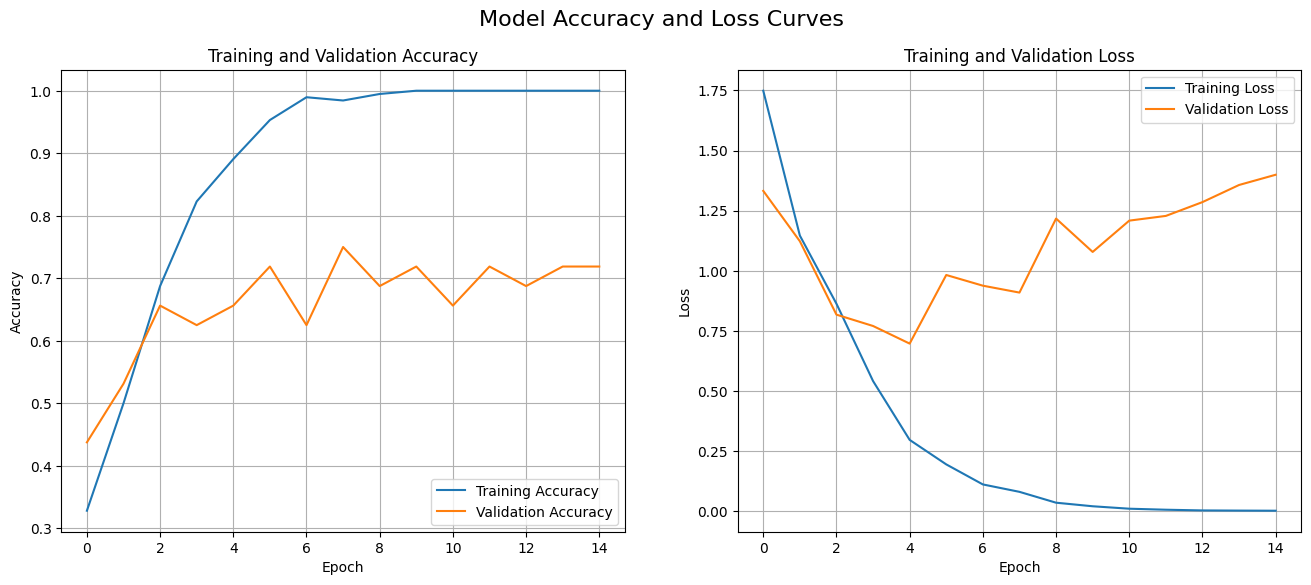

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Membuat plot
plt.figure(figsize=(16, 6))

# Plot untuk Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# Plot untuk Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Menampilkan grafik
plt.suptitle('Model Accuracy and Loss Curves', fontsize=16)
plt.show()

Class Names untuk Confusion Matrix: ['nasi_liwet', 'panada', 'rawon', 'rendang']
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


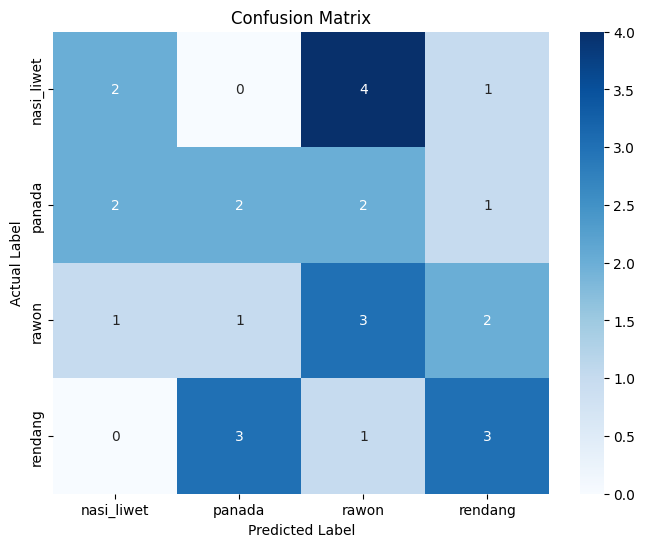

In [ ]:
import seaborn as sns

train_dir = '../dataset_split/train' # Pastikan path ini sesuai
class_names = sorted(os.listdir(train_dir))
print(f"Class Names untuk Confusion Matrix: {class_names}")

# Mengambil label asli dari test_ds
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Melakukan prediksi pada seluruh data tes
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Menghitung confusion matrix
cm = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()

# Membuat visualisasi confusion matrix menggunakan Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()